In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import re
import cv2
import time
import matplotlib.cm as cmx
import matplotlib.colors as colors
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [5]:
results_dir = '../darknet/parse/parsed'
data_dir = '../orig_data'
results = [name for name in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, name))]

In [6]:
def scale_box(df, im):
    predict_im_size = 832.
    df = df.copy(deep = True)
    df.columns = ['prob', 'x', 'y', 'w', 'h', 'player']

    # Vertical is stretched as the same as width, rest is filled with blank space
    im_height, im_width, _ = im.shape
    width_scale = im_width / predict_im_size
    height_scale = im_height / predict_im_size
    scale_diff = (predict_im_size - (im_height / width_scale)) / 2.
    
    df.iloc[:,[1,3]] = np.round(df.iloc[:,[1,3]] * width_scale)
    df.iloc[:,[2,4]] = np.round((df.iloc[:,[2,4]] - scale_diff) * width_scale)
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

In [7]:
def show_image(im):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.] )
    ax.set_axis_off( )
    fig.add_axes(ax)
    
    ax.imshow(im)
    return ax

In [8]:
def xywh_2_ltbr(df):
    df = df.copy(deep=True)
    df.columns = ['prob', 'x1', 'y1', 'x2', 'y2', 'player']
    df.iloc[:,3] = df.iloc[:,3] + df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] + df.iloc[:,2]
    
    return df

def ltbr_2_xywh(df):
    df = df.copy(deep=True)
    df.columns = ['prob', 'x', 'y', 'w', 'h', 'player']
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

In [9]:
def is_intersecting(df):
    df = xywh_2_ltbr(df)
    result_array = []
    for index, data in df.iterrows():
        result = np.array(np.logical_not((df.x1 > data.x2) |
                                         (df.x2 < data.x1) | 
                                         (df.y1 > data.y2) | 
                                         (df.y2 < data.y1)))
        result_array = np.append(result_array, result)
    result_array = result_array.reshape((df.shape[0], df.shape[0]))
    np.fill_diagonal(result_array, 0)
    return result_array

def pick_max(df, value):
    df = df.copy(deep = True)
    return df.map(lambda x: x if x >= value else value)

def pick_min(df, value):
    df = df.copy(deep = True)
    return df.map(lambda x: x if x <= value else value)

def box_and_overlap_area(df, conversion = False):
    if conversion is True:
        df_ltbr = xywh_2_ltbr(df)
    else:
        df_ltbr = df.copy(deep = True)
        df_ltbr.columns = ['prob', 'x1', 'y1', 'x2', 'y2']
    
    result_array = []
    for index, data in df_ltbr.iterrows():
        left = pick_max(df_ltbr['x1'], data.x1)
        right = pick_min(df_ltbr['x2'], data.x2)
        top = pick_max(df_ltbr['y1'], data.y1)
        bot = pick_min(df_ltbr['y2'], data.y2)
        
        height = pick_max((bot - top), 0)
        width = pick_max((right - left), 0)
        
        result_array = np.append(result_array, height * width)
    result_array = result_array.reshape((df.shape[0], df.shape[0]))
    
    return result_array

def overlap_frames(prev, curr, conversion = False, shift_scale = 0.3):
    if conversion is True:
        prev_ltbr = xywh_2_ltbr(prev)
        curr_ltbr = xywh_2_ltbr(curr)

    else:
        prev_ltbr = prev.copy(deep = True)
        curr_ltbr = curr.copy(deep = True)
        
    # Shift based on average position of the boxes
    shift = calculate_shift(curr_ltbr, prev_ltbr)
    scaled_shift = np.array(shift) * shift_scale
    
    # Scale based on average size of the boxes
    # curr_box = box_area_frame(curr)
    # prev_box = box_area_frame(prev)
    # scale = calculate_scale(curr_box, prev_box)
    scale = 1.
    
    result_array = []
    for index, data in prev_ltbr.iterrows():
        left = pick_max(curr_ltbr['x1'], data.x1 / scale - scaled_shift[0] )
        right = pick_min(curr_ltbr['x2'], data.x2  / scale - scaled_shift[0])
        top = pick_max(curr_ltbr['y1'], data.y1 / scale - scaled_shift[1])
        bot = pick_min(curr_ltbr['y2'], data.y2  / scale - scaled_shift[1])
        
        height = pick_max((bot - top), 0)
        width = pick_max((right - left), 0)
        
        result_array = np.append(result_array, height * width)
    result_array = result_array.reshape((prev_ltbr.shape[0], curr_ltbr.shape[0]))
    
    return result_array

def box_area_frame(frame):
    new_frame = ltbr_2_xywh(frame)
    return new_frame.w * new_frame.h

def separate_box_and_overlap(combined):
    box_area = np.diagonal(combined).copy()
    np.fill_diagonal(combined, 0)
    
    return box_area, combined

def overlap_area(df):
    overlap_area = box_and_overlap_area(df)
    np.fill_diagonal(overlap_area, 0)
    return overlap_area

def box_area(df):
    box_area = box_and_overlap_area(df)
    return np.diagonal(box_area)

def overlap_percentage(box_area, overlap_area):
    iu1 = np.triu_indices(overlap_area.shape[1])
    overlap_area[iu1] = 0
    overlap_coordinates = np.nonzero(overlap_area)
    
    box1, box2 = overlap_coordinates
    
    result_array = []
    for i in xrange(box1.shape[0]):
        specific_overlap_area = overlap_area[box1[i], box2[i]]
        total_area = box_area[box1[i]] + box_area[box2[i]] - specific_overlap_area
        percentage = specific_overlap_area / total_area
        result_array.append(percentage)
    
    return result_array

def calculate_shift(curr, prev):
    mid_curr = calculate_mid_point(curr)
    mid_prev = calculate_mid_point(prev)
    
    x_shift = np.mean(mid_curr.x - mid_prev.x)
    y_shift = np.mean(mid_curr.y - mid_prev.y)

    return [x_shift, y_shift]

def calculate_scale(curr_box, prev_box):
    return np.mean(curr_box) / np.mean(prev_box)

In [10]:
def add_player_column(df, value = -1):
    df['player'] = value
    df.columns = ['prob', 'x1', 'y1', 'x2', 'y2', 'player']

def init_player_column(df):
    num_rows = df.shape[0]
    df['player'] = range(0, num_rows)
    df.columns = ['prob', 'x1', 'y1', 'x2', 'y2', 'player']

In [11]:
def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

In [12]:
class PlayerId:
    def __init__(self, initial = 0):
        self.current_id = initial
        self.cmap = get_cmap(60) # 20 frames x 10 players
    
    def set_id(self, player_id):
        self.current_id = player_id
        
    def new_id(self):
        self.current_id = self.current_id + 1
        return self.current_id
    
    def get_id(self):
        return self.current_id
    
    def get_colour(self, player_id):
        return self.cmap(player_id)

In [13]:
# calculate box in csv1 has the most overlapped with csv2
def most_overlapped(curr, prev, threshold = 0.05):
    overlap_area = overlap_frames(curr, prev, False)
    curr_box = box_area_frame(curr)
    prev_box = box_area_frame(prev)
    box1, box2 = np.nonzero(overlap_area)
    
    for i in range(box1.shape[0]):
        overlap = overlap_area[box1[i], box2[i]]
        total_area = curr_box[box1[i]] + prev_box[box2[i]] - overlap
        percentage = overlap / total_area
        overlap_area[box1[i], box2[i]] = percentage
    
    overlap_area = np.array(overlap_area).flatten()
    index = overlap_area < threshold
    overlap_area[index] = 0
    overlap_area = overlap_area.reshape((curr.shape[0], prev.shape[0]))
    assignment = np.argmax(overlap_area, axis = 1)
    
    counter = 0
    index = duplicate_assignment(assignment)
    print index
    while(index):
        for key, values in index.items():
            items = []
            for value in values:
                items.append(overlap_area[value][key])

            max_index = np.argmax(items)
            for i in xrange(len(items)):
                if i != max_index:
                    overlap_area[values[i]][key] = 0

        assignment = np.argmax(overlap_area, axis = 1)
        index = duplicate_assignment(assignment)
   
    new = (np.sum(overlap_area, axis = 1) == 0)
        
    return new, assignment

def assignment_overlap(assignment):
    print np.unique(assignment, return_inverse = True, return_index = True)
    
def duplicate_index(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

def duplicate_assignment(lst):
    uniq, index, count  = np.unique(lst, return_counts=True, return_inverse = True)
    result = {}
    for i in range(len(count)):
        if count[i] > 1 and uniq[i] != 0:
            result[uniq[i]] = duplicate_index(lst, uniq[i])

    return result    

In [500]:
a = [4, 1, 2, 2, 0, 4, 0, 3, 5, 6]
duplicate_assignment(a)

{2: [2, 3], 4: [0, 5]}

In [241]:
def divide_image(frame, img):
    image_list = []
    scaled = scale_box(frame, img)
    for box in scaled.iterrows():
        box = box[1]
        x_limit = int(box[1] + box[3])
        y_limit = int(box[2] + box[4])
        
        cropped = img[int(box[2]):y_limit,int(box[1]):x_limit]
        image_list.append(cropped)
    return image_list

def calculate_histogram(image_list):
    hist_list = []
    for img in image_list:
        hist = [cv2.calcHist([img],[i],None,[256],[0,256]) for i in xrange(0,3)]
        hist = np.ravel(hist)
        hist_list.append(hist)
    return hist_list

def initialize_histogram(frame, img_path):
    img = cv2.imread(img_path)
    image_list = divide_image(frame, img)
    hist_list = calculate_histogram(image_list)
    return hist_list

def closest_histogram(curr_hist_list, prev_hist_list):
    argmin_list = []
    full_distance_list = []
    for curr_hist in curr_hist_list:
        diff = np.abs(np.sum(prev_hist_list - curr_hist, axis = 1))
        argmin = np.argmin(diff)
        argmin_list.append(argmin)
        full_distance_list.append(diff)
    return argmin, full_distance_list

def calculate_sift(image_list):
    sift = cv2.xfeatures2d.SIFT_create()
    sift_list = []
    for img in image_list:
        _, des = sift.detectAndCompute(img, None)
        sift_list.append(des)
    return sift_list

def initialize_sift(frame, img_path):
    img = cv2.imread(image_path)
    image_list = divide_image(frame, img)
    sift_list = calculate_sift(image_list)
    return sift_list

def closest_sift(curr_sift_list, prev_sift_list):
    bf = cv2.BFMatcher()
    argmin_list = []
    full_distance_list = []
    for curr_sift in curr_sift_list:
        distance_list = []
        for prev_sift in prev_sift_list:
            matches = bf.knnMatch(curr_sift, prev_sift, k = 2)
            distance_average = np.mean(np.sort([m.distance for m, n in matches])[:15])
            distance_list.append(distance_average)
        argmin = np.argmin(distance_list)
        argmin_list.append(argmin)
        full_distance_list.append(distance_list)
    
    return argmin_list, np.array(full_distance_list)
        
def duplicate_assignment_sift(lst):
    max_value = 99999
    uniq, index, count  = np.unique(lst, return_counts=True, return_inverse = True)
    result = {}
    for i in range(len(count)):
        if count[i] > 1 and uniq[i] != max_value:
            result[uniq[i]] = duplicate_index(lst, uniq[i])
    return result

def combined_matching(image_path, curr, prev, prev_sift_list, prev_hist_list):
    max_value = 99999
    curr_sift_list = initialize_sift(curr, image_path)
    curr_hist_list = initialize_histogram(curr, image_path)
    sift_assignment, sift_distance = closest_sift(curr_sift_list, prev_sift_list)
    hist_assignment, hist_distance = closest_histogram(curr_hist_list, prev_hist_list)
    
    normalize_scale_hist = np.max(hist_distance) - np.min(hist_distance)
    normalized_hist = (hist_distance - np.min(hist_distance)) / normalize_scale_hist
    
    normalize_scale_sift = np.max(sift_distance) - np.min(sift_distance)
    normalized_sift = (sift_distance - np.min(sift_distance)) / normalize_scale_sift
    
    dist = [0.5, 2, 1]
    combination = normalized_hist * dist[0] + normalized_sift * dist[1]
    
    # Adding distance penalty
    penalty = distance_penalty(curr, prev)
    comb_with_penalty = combination + penalty * dist[2]
    
    assignment = np.argmin(comb_with_penalty, axis = 1)
    duplicate = duplicate_assignment_sift(assignment)
    new = np.zeros(len(assignment))    
    while(duplicate):
        for key, values in duplicate.items():
            items = [combination[i][key] for i in values]
            min_index = np.argmin(items)
            for i in xrange(len(items)):
                if i != min_index:
                    combination[values[i]][key] = max_value
        
        comb_with_penalty = combination + penalty * dist[2]
        assignment = np.argmin(comb_with_penalty, axis = 1)
        
        new = np.mean(combination, axis = 1) == max_value
        if np.sum(new) != 0:
            indicies = np.argwhere(new == True)
            for index in indicies:
                assignment[index] = max_value
        
        duplicate = duplicate_assignment_sift(assignment)
        
    # Row full of max_value means new assignment
    new = assignment == max_value
    return assignment, new, curr_sift_list, curr_hist_list
    
    
def sift_matching(image_path, curr, prev_sift_list):
    max_value = 99999
    curr_sift_list = initialize_sift(curr, image_path)
    assignment, distance = closest_sift(curr_sift_list, prev_sift_list)
    
    duplicate = duplicate_assignment_sift(assignment)
    new = np.zeros(len(assignment))
    while(duplicate and np.sum(new) == 0):
        for key, values in duplicate.items():
            items = [distance[i][key] for i in values]
            min_index = np.argmin(items)
            for i in xrange(len(items)):
                if i != min_index:
                    distance[values[i]][key] = max_value
        assignment = np.argmin(distance, axis = 1)
        duplicate = duplicate_assignment_sift(assignment)
        
        # Row full of max_value means new assignment
        new = np.mean(distance, axis = 1) == max_value
    return assignment, new, curr_sift_list

In [257]:
def distance_penalty(curr, prev):
    distance_list = []
    for row in curr.iterrows():
        row = row[1]
        curr_coord = [row.x1, row.y1]
        prev_coord = prev.loc[:,['x1', 'y1']]
        distance = np.linalg.norm(prev_coord - curr_coord, axis = 1)
        distance_list.append(distance)
    distance_list = rescale_values(distance_list)
    return distance_list

def rescale_values(values):
    scale = np.max(values) - np.min(values)
    scaled = (values - np.min(values)) / scale
    
    return scaled

def add_to_dict(dictionary, df, i):
    for row in df.iterrows():
        row = row[1]
        player = row['player']
        coordinates = np.array(row.iloc[1:5].as_matrix(), dtype = int)
        coordinates = np.append(coordinates, i)
        if player in dictionary:
            dictionary[player].append(coordinates)
        else:
            dictionary[player] = [coordinates]
    return dictionary

def save_dict_to_csv(dictionary, csv_file_path, video_id, clip_id):
    for key in dictionary:
        df = pd.concat([pd.DataFrame(item).transpose() for item in dictionary[key]])
        df.columns = ['x1', 'y1', 'x2', 'y2', 'frame_number']
        csv_file_name = os.path.join(csv_file_path, '%s_%s_player_%02d.csv' % (video_id, clip_id, int(key)))
        df.to_csv(csv_file_name, index = False)

# SIFT MATCHING

In [293]:
video_id = 'WpH85OZMxZ0'
clip_id  = 'clip_38'
image_dir = os.path.join(data_dir, video_id, clip_id)
results2 = [name for name in os.listdir(image_dir) if 'png' in name]
results2.sort()

# Read the first file and set id
csv_name = video_id + '_' + clip_id + '_' + '01.txt'
csv_path = os.path.join(results_dir, csv_name)
image_path = os.path.join(data_dir, video_id, clip_id, '01.png')

prev = pd.read_csv(csv_path, header = None)
init_player_column(prev)
player_id = PlayerId(prev.shape[0] - 1)
prev_sift_list = initialize_sift(prev, image_path)
prev_hist_list = initialize_histogram(prev, image_path)
path_dict = {}

add_to_dict(path_dict, prev, 0)
for i in range(1, len(results2)):
    result = results2[i].split('.')[0]
    
    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    image_path = os.path.join(data_dir, video_id, clip_id, result + '.png')
    csv_path = os.path.join(results_dir, csv_name)
    curr = pd.read_csv(csv_path, header = None)
    add_player_column(curr)
    
    hist = initialize_histogram(curr, image_path)
    closest_histogram(hist, hist)
    
    # Calculate
    #assignment, new, prev_sift_list = sift_matching(image_path, curr, prev_sift_list)
    assignment, new, prev_sift_list, prev_hist_list = combined_matching(image_path, curr, prev, prev_sift_list, prev_hist_list)
    assign_player(curr, prev, player_id, new, assignment)
    add_to_dict(path_dict, curr, i)
    # distance_penalty(curr, prev)
    # produce_image_overlap(curr, image_path, player_id, truth = True)

    prev = curr
    #print assignment, new

save_dict_to_csv(path_dict, './results', video_id, clip_id)

In [240]:
def assign_player(curr, prev, player_id, new, assignment):
    for i in range(curr.shape[0]):
        if new[i] == False:
            curr.loc[i, 'player'] = prev.player[assignment[i]]
        else:
            curr.loc[i, 'player'] = player_id.new_id()

{}
{}
{1: [0, 1]}
{}
{}
{2: [1, 2]}
{4: [1, 3]}
{3: [1, 2, 5]}
{}
{}
{}
{7: [4, 7]}
{}
{}
{}
{4: [2, 4]}
{2: [1, 5], 5: [0, 6]}
{}
{2: [2, 3, 4]}


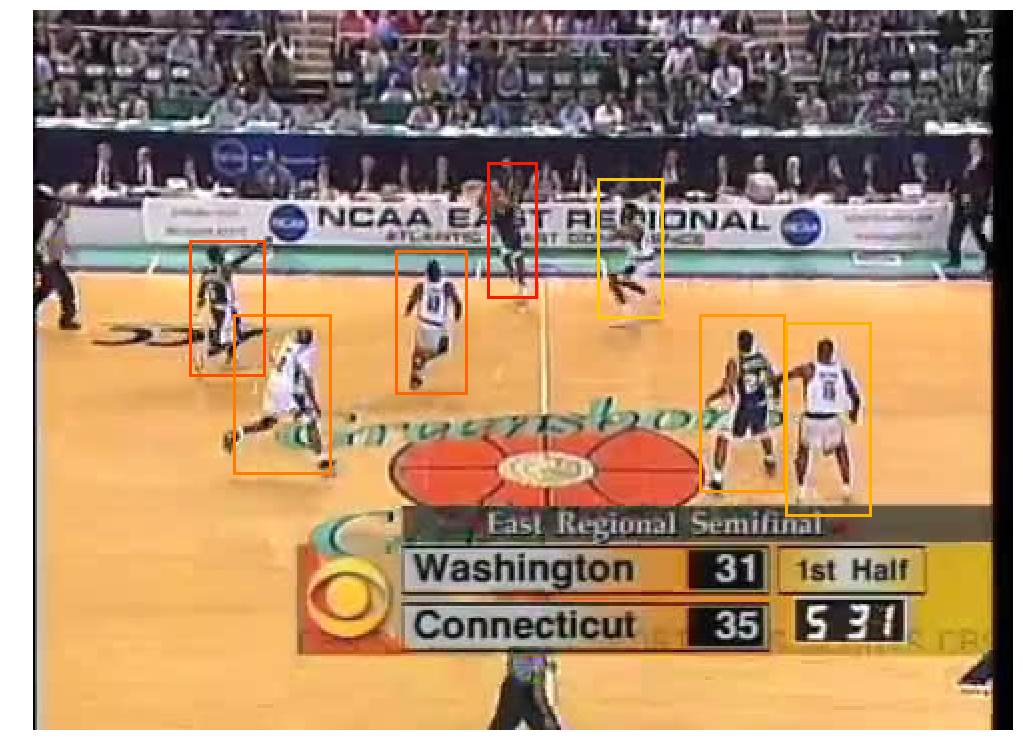

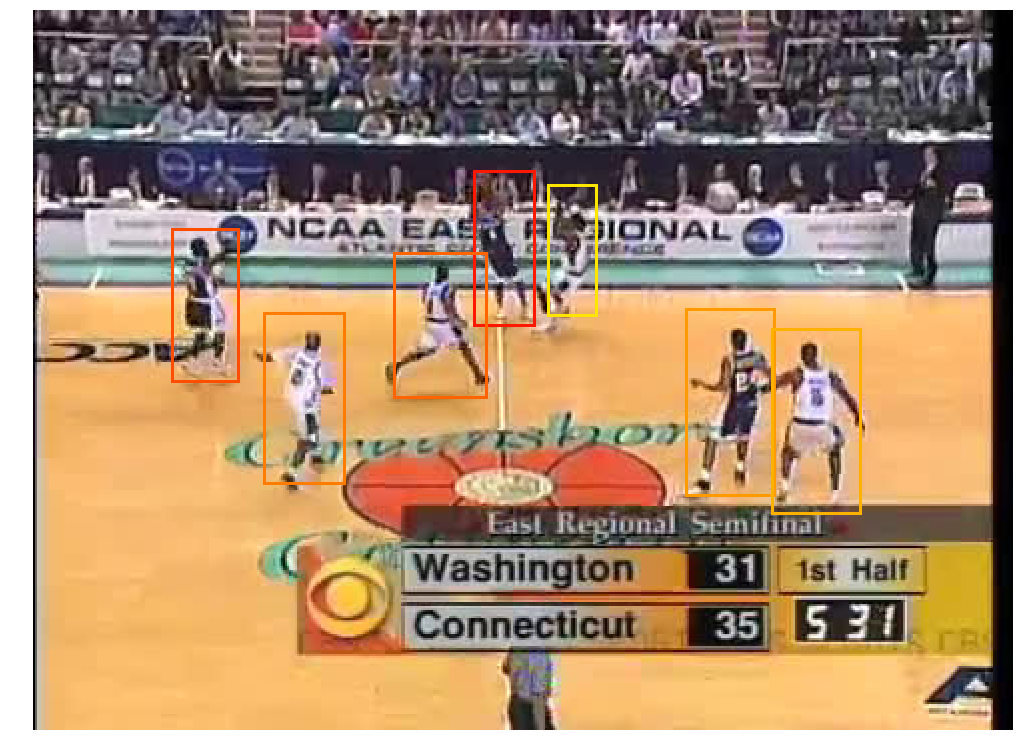

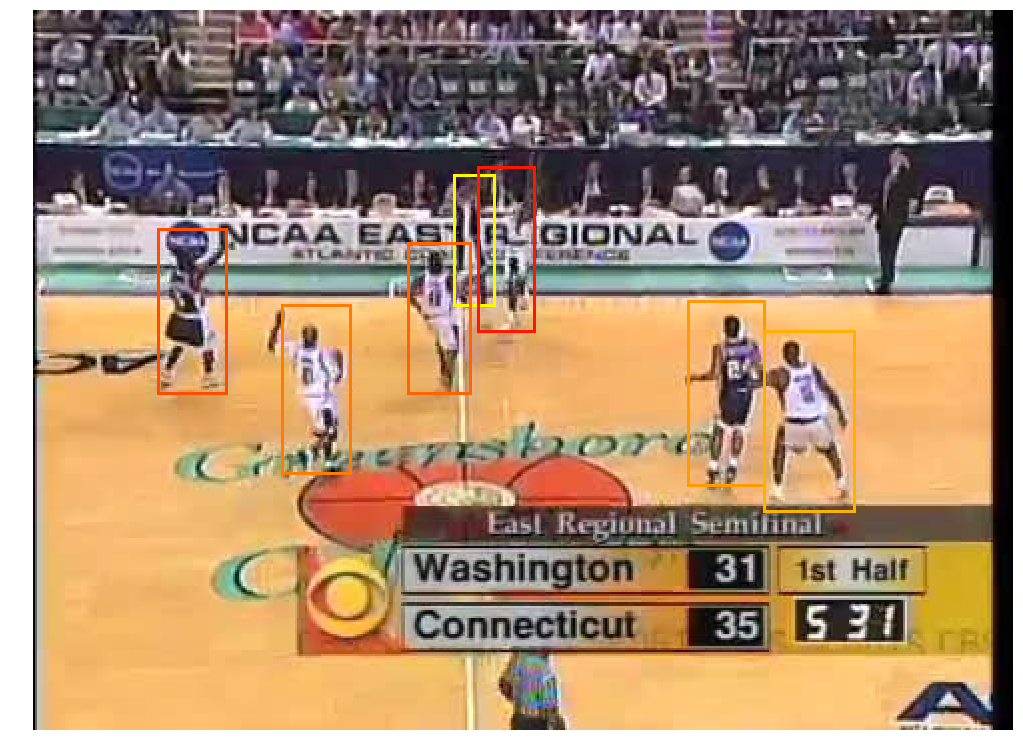

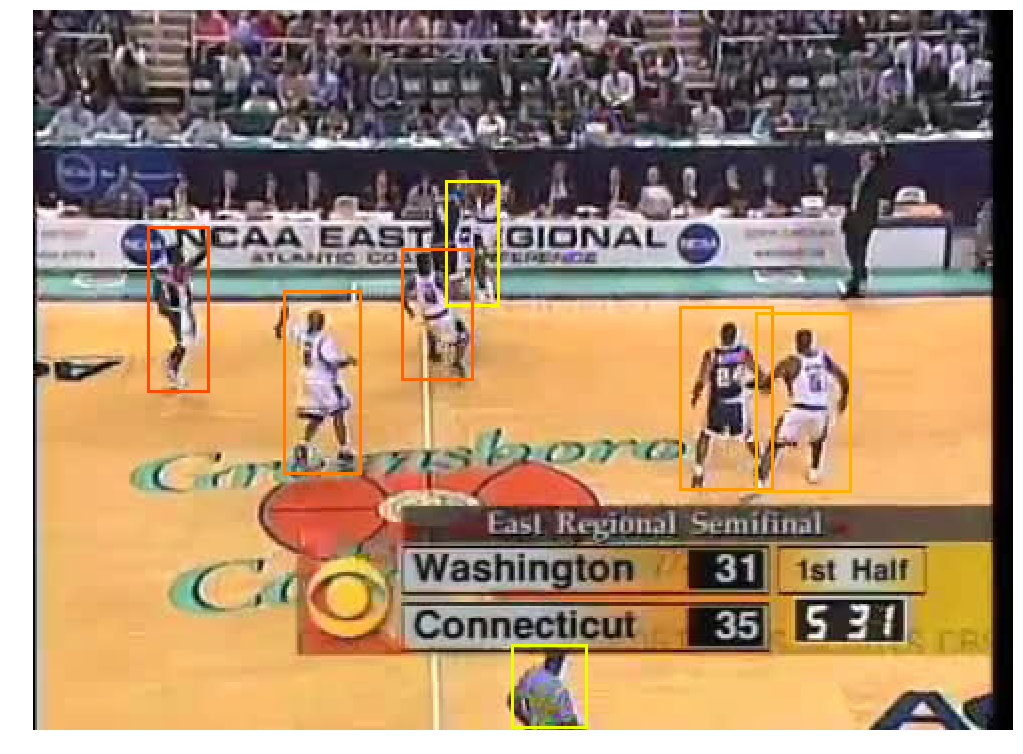

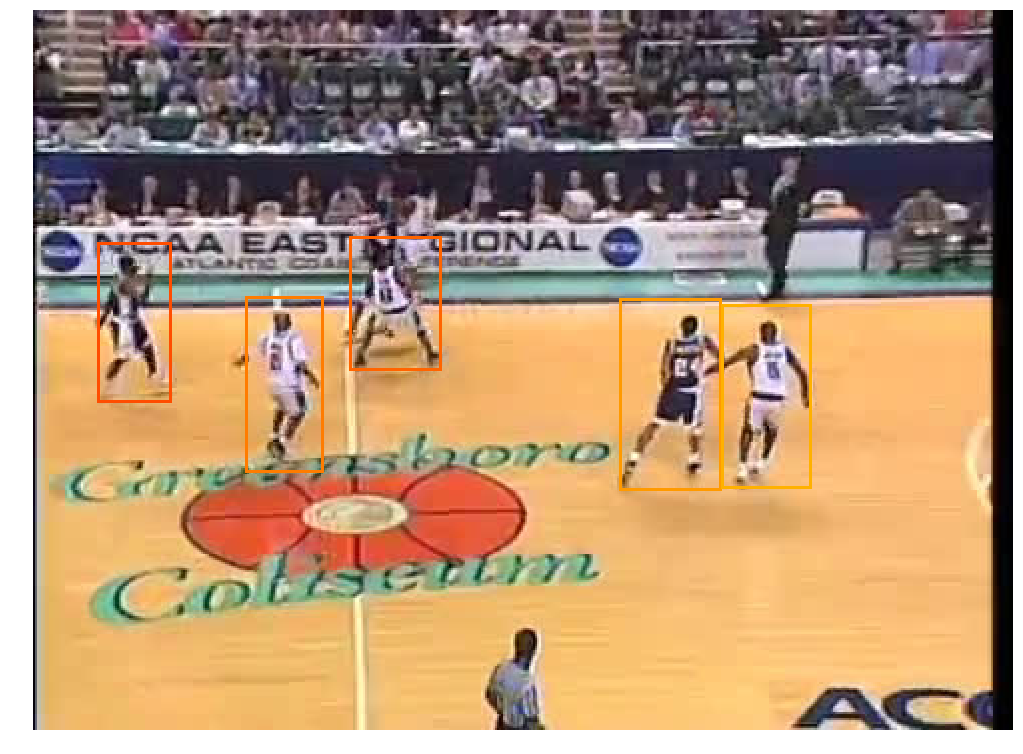

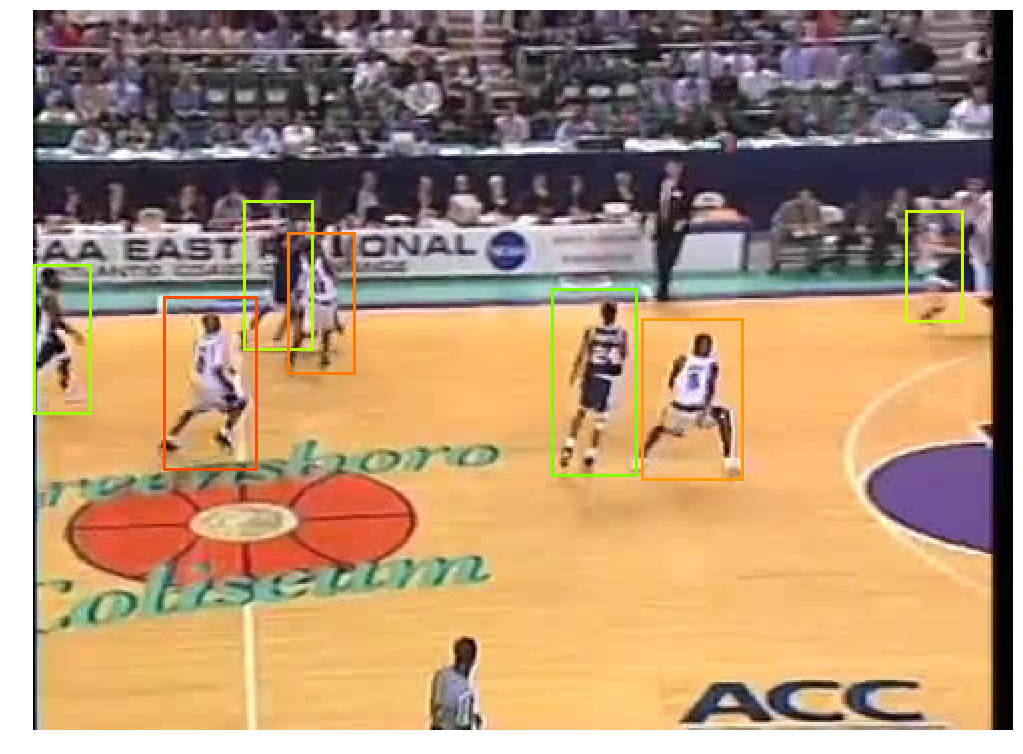

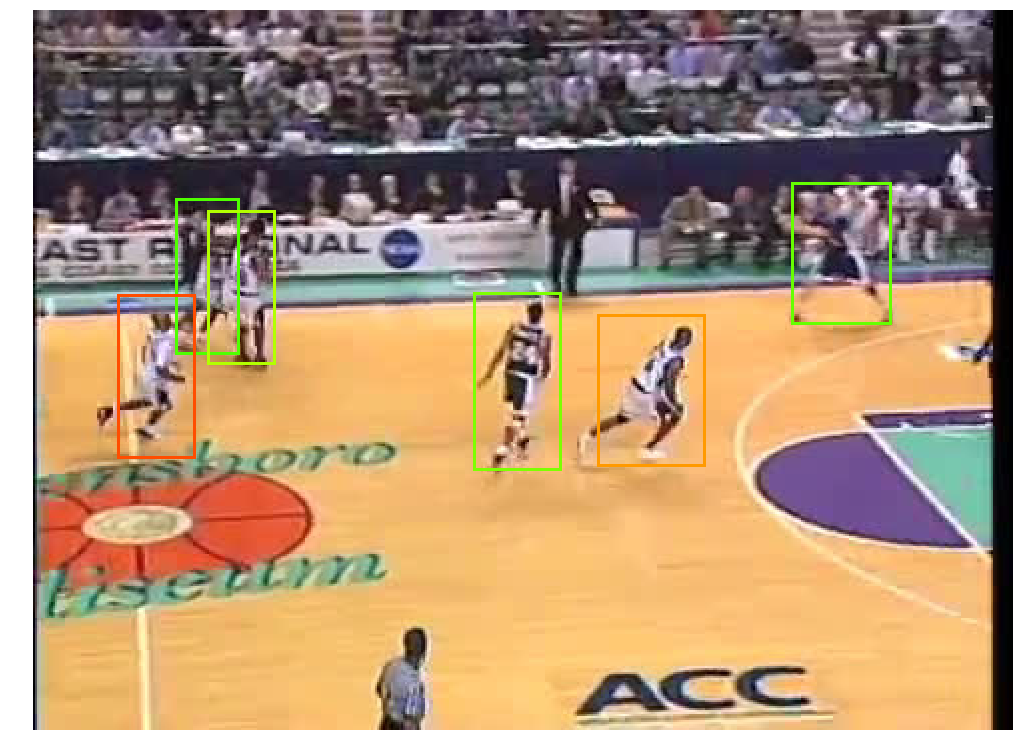

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


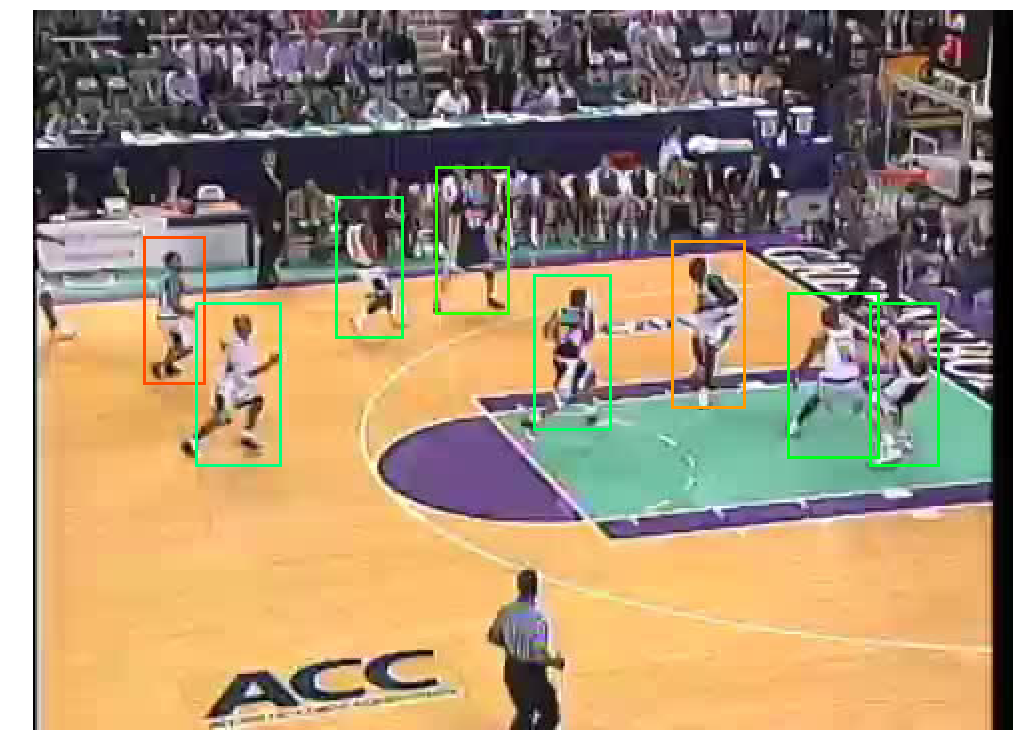

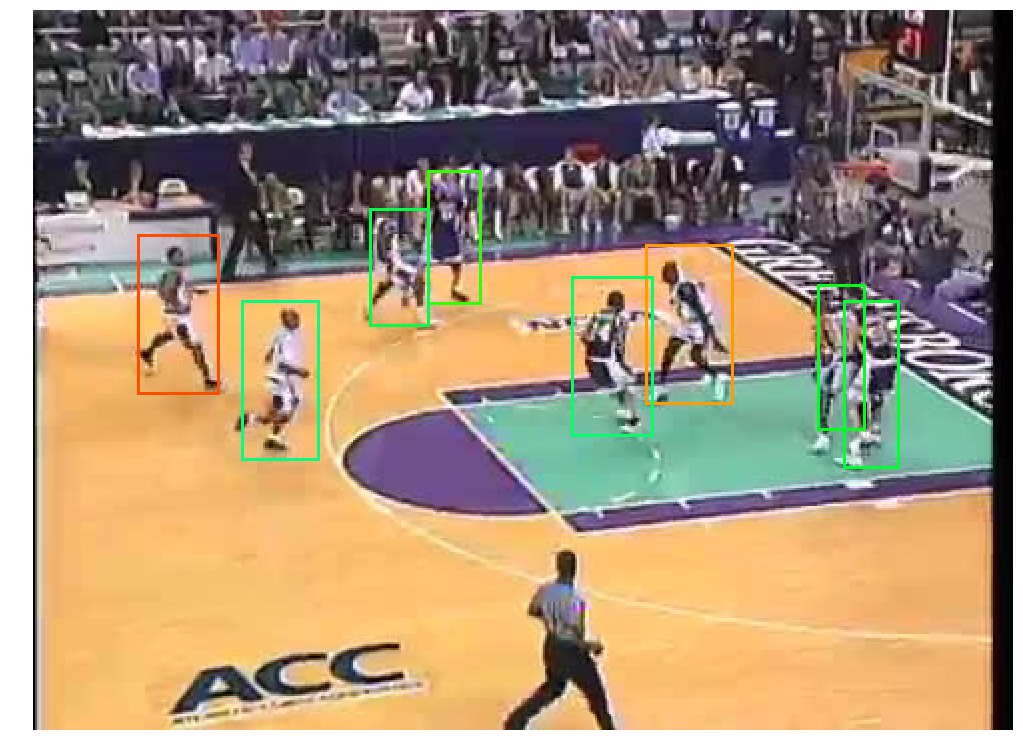

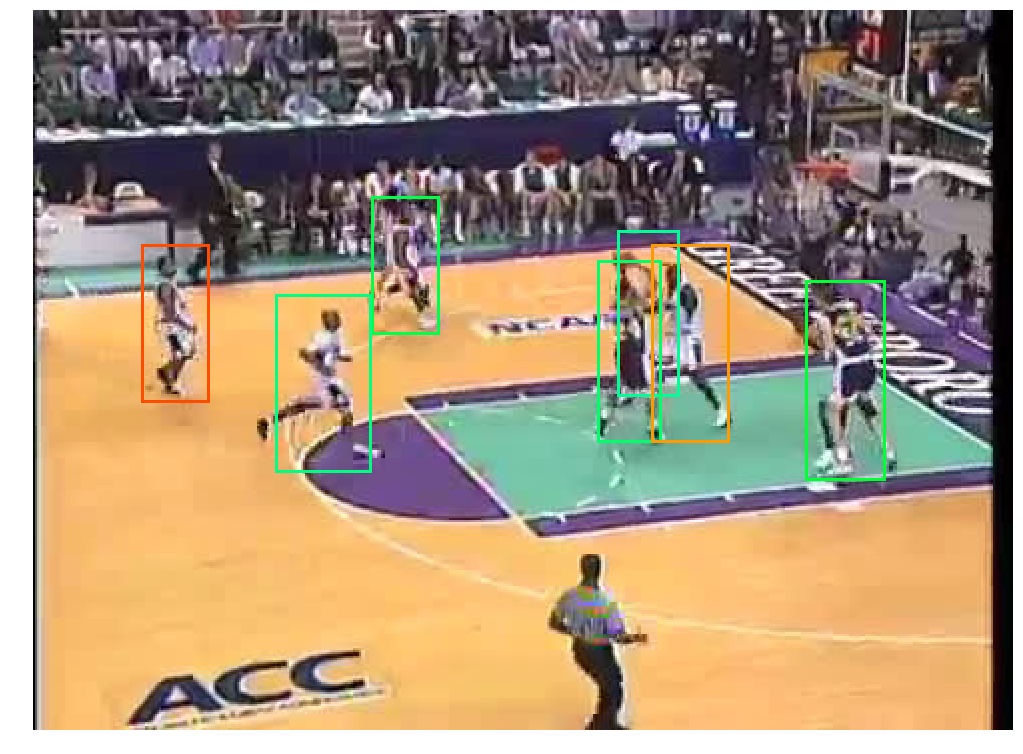

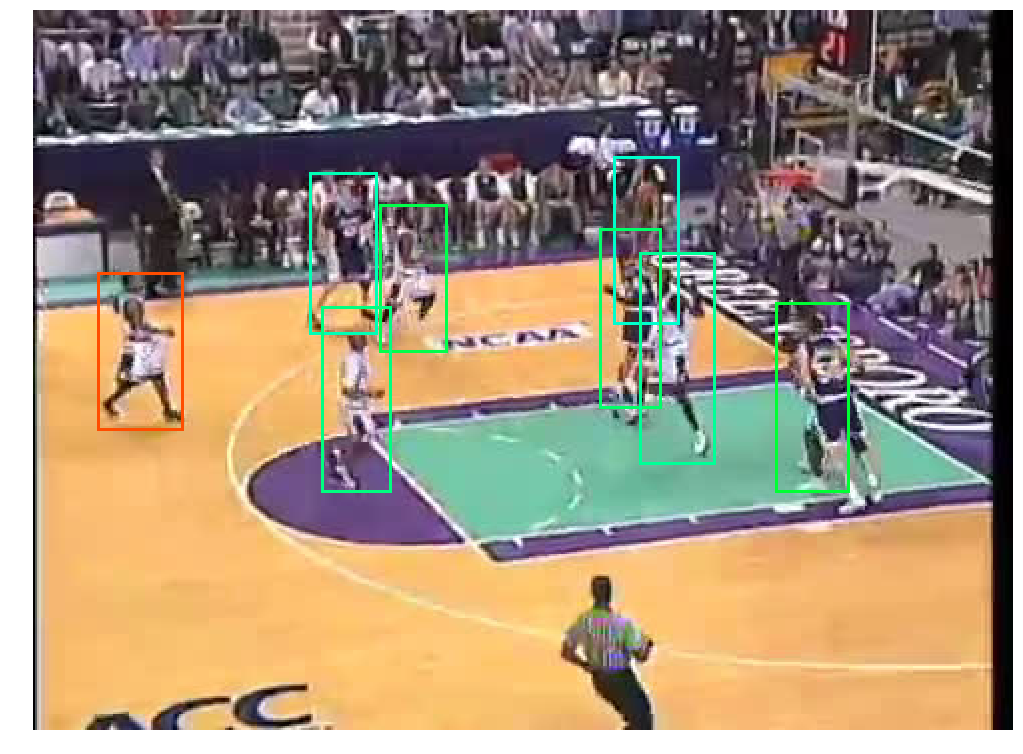

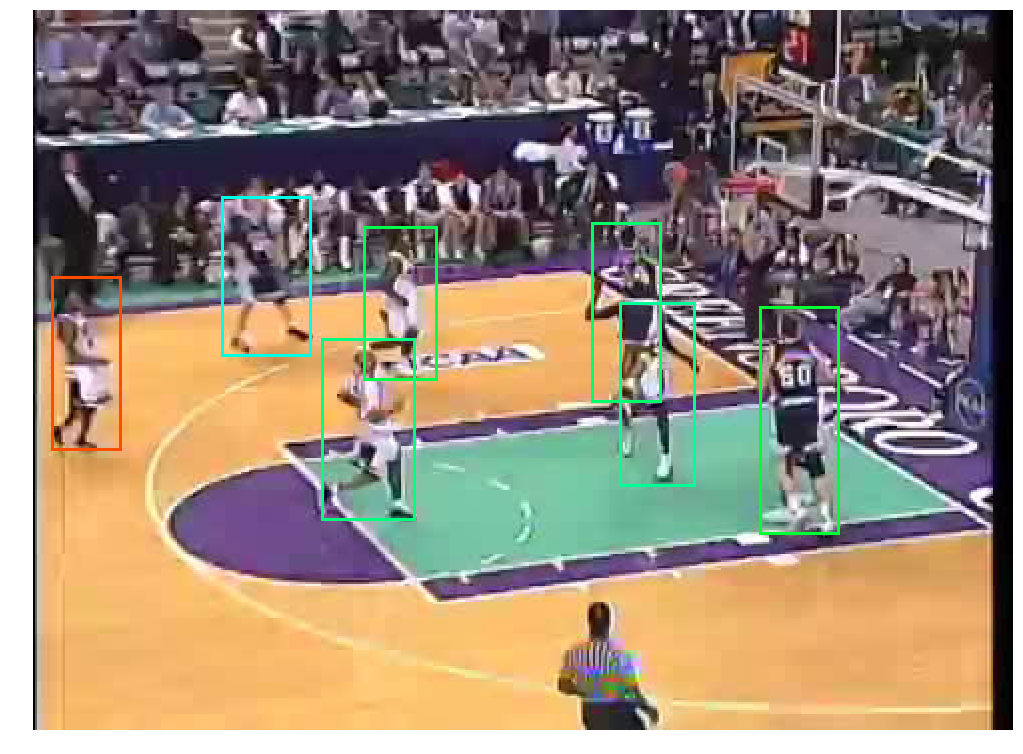

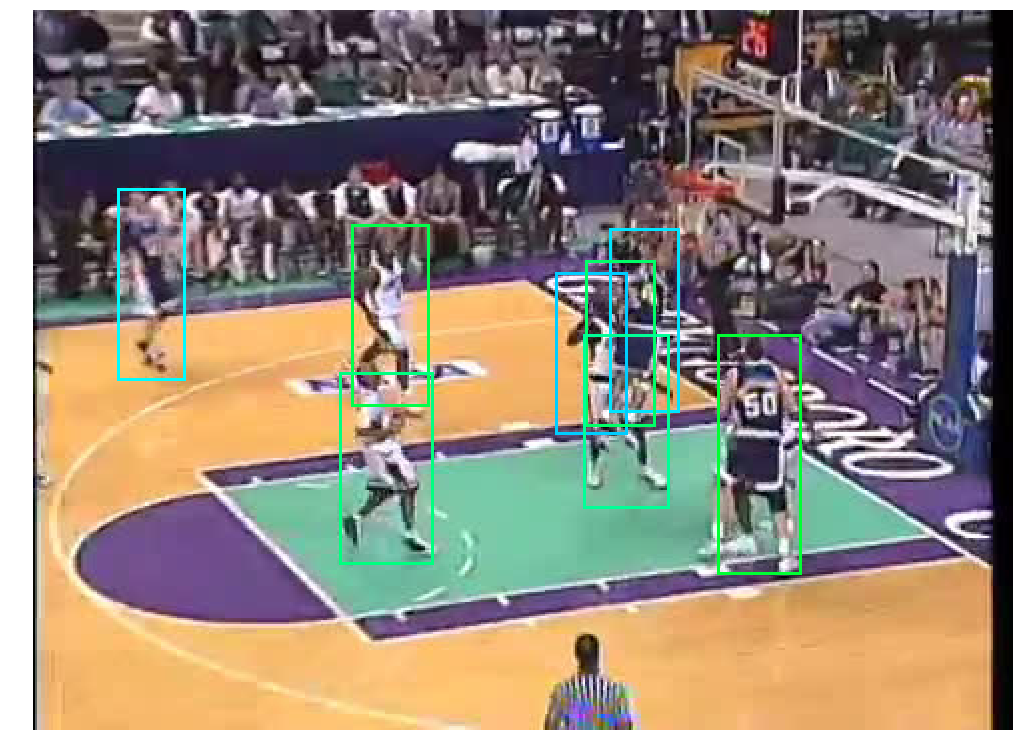

In [291]:
video_id = 'WpH85OZMxZ0'
clip_id  = 'clip_27'
image_dir = os.path.join(data_dir, video_id, clip_id)
results2 = [name for name in os.listdir(image_dir) if 'png' in name]
results2.sort()

skip_counter = 0
prev_csv_file = ''

# Read the first file and set id
csv_name = video_id + '_' + clip_id + '_' + '01.txt'
csv_path = os.path.join(results_dir, csv_name)
prev = pd.read_csv(csv_path, header = None)
init_player_column(prev)
player_id = PlayerId(prev.shape[0] - 1)

for i in range(1, len(results2)):
    result = results2[i].split('.')[0]
    
    # Read the files
    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    csv_path = os.path.join(results_dir, csv_name)
    curr = pd.read_csv(csv_path, header = None)
    add_player_column(curr)
    
    # Calculate
    new, assignment = most_overlapped(curr, prev)
    assign_player(curr, prev, player_id, new, assignment)
    
    # Get video information
    image_path = os.path.join(data_dir, video_id, clip_id, result + '.png')
    produce_image_overlap(curr, image_path, player_id)
    # Feed the Curr into display
    prev = curr

In [396]:
csvpath_1 = '../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_01.txt'
csvpath_2 = '../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_02.txt'

csv_1 = pd.read_csv(csvpath_1, header = None)
csv_2 = pd.read_csv(csvpath_2, header = None)

# Initialize player numbering
player_id = PlayerId(csv_1.shape[0] - 1)
# Initialize the columns
init_player_column(csv_1)
add_player_column(csv_2)

# Get the values for most overlapped
new, assignment = most_overlapped(csv_2, csv_1)
assign_player(csv_2, player_id, new, assignment)
# Match the players with each other, create new player if it's new

print csv_2

       prob   x1   y1   x2   y2  player
0  0.546414  100  308  134  423       0
1  0.698210  159  309  193  425       2
2  0.676143  191  310  226  432       3
3  0.701490   58  341   94  472       5
4  0.496738  117  342  150  467       1
5  0.654664  555  383  610  503       8
6  0.610026  606  375  664  486       7


In [21]:
def calculate_mid_point(df, conversion = False):
    if conversion is True:
        df_ltbr = xywh_2_ltbr(df)
    else:
        df_ltbr = df.copy(deep = True)
        df_ltbr.columns = ['prob', 'x1', 'y1', 'x2', 'y2', 'player']
    mid_x = (df_ltbr.x1 + df_ltbr.x2) / 2.
    mid_y = (df_ltbr.y1 + df_ltbr.y2) / 2.
    
    new_frame = pd.concat([mid_x, mid_y], axis = 1)
    new_frame.columns = ['x', 'y']
    
    return new_frame

def calculate_distance_from_each(midpoint_df):
    result_array = []
    for index, data in midpoint_df.iterrows():
        diff = midpoint_df - data
        diff = diff.applymap(lambda x: np.power(x,2))
        diff = np.sqrt(diff.sum(axis = 1))
        result_array = np.append(result_array, diff)
    result_array = result_array.reshape((dist_df.shape[0], dist_df.shape[0]))
    print result_array

def calculate_dist_between_frame(curr_frame, next_frame):
    result_array = []
    for index, data in curr_frame.iterrows():
        diff = next_frame - data
        diff = diff.applymap(lambda x: np.power(x,2))
        diff = np.sqrt(diff.sum(axis = 1))
        result_array = np.append(result_array, diff)
    result_array = result_array.reshape((curr_frame.shape[0], next_frame.shape[0]))
    return result_array

In [22]:
def reorder_df(players, curr):
    new_players = players.copy(deep = True)
    print players
    print curr
    dist = calculate_dist_between_frame(players, curr)
    print dist
    assignment = np.argmin(dist, axis = 1)
    for index, data in new_players.iterrows():
        if np.isnan(data['x']) == False:
            data['x'] = players.iloc[assignment[index], 0]
            data['y'] = players.iloc[assignment[index], 1]
    return new_players, assignment

In [259]:
video_id = 'WF0GqBJuBLQ'
clip_id  = 'clip_65'
image_dir = os.path.join(data_dir, video_id, clip_id)
results2 = [name for name in os.listdir(image_dir) if 'png' in name]
results2.sort()

skip_counter = 0
prev_csv_file = ''
players_mid = pd.DataFrame(np.nan, index=range(0,10), columns=['x', 'y'])
for result in results2:
    skip_counter = skip_counter + 1
    #if skip_counter < 1:
    #    continue
    
    result = result.split('.')[0]
    
    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    csv_path = os.path.join(results_dir, csv_name)
    csv_file = pd.read_csv(csv_path, header = None)
    curr = calculate_mid_point(csv_file)
    if skip_counter == 1:
        players_mid.loc[curr.index, curr.columns] = curr
        assignment = range(0,10)
    else:
        players_mid, assignment = reorder_df(players_mid, curr)
    
    # print skip_counter
    # print overlap_percentage(csv_file)
    print assignment
    produce_image(csv_path, assignment, bounding_box = True ,truth = False)
    prev_csv_file = csv_file
    
    if skip_counter > 2:
        break;

ValueError: Length mismatch: Expected axis has 5 elements, new values have 6 elements

In [ ]:
result_array = []
counter = 0
for result in results:
    csv_path = os.path.join(results_dir, result)
    csv_file = pd.read_csv(csv_path, header = None)
    
    result = overlap_percentage(csv_file)
    result_array = np.append(result_array, result)
    counter = counter + 1
print counter

In [349]:
df = pd.DataFrame(result_array)

                  0
count  51851.000000
mean       0.126082
std        0.101687
min        0.000031
25%        0.042930
50%        0.099654
75%        0.186071
max        0.421559


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06db98b1d0>]], dtype=object)

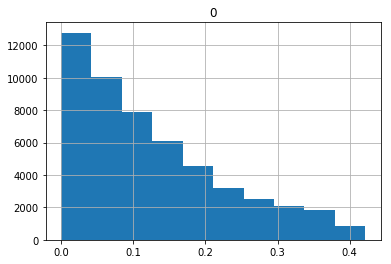

In [353]:
print df.describe()
df.hist()

In [278]:
path = '../orig_data/WF0GqBJuBLQ/clip_65/02.png'
print re.search('.*(?=(clip_))', path).group(0).split('/')[-2]
get_video_info(path)

WF0GqBJuBLQ


('WF0GqBJuBLQ', 'clip_65', '02')

In [289]:
colour = ['peru', 'green', 'violet', 'red', 'teal', 'blue', 'pink', 'brown', 'sandybrown', 'beige']
def get_video_info(path):
    video_id = re.search('.*(?=(clip))', path).group(0).split('/')[-2]
    clip_id = re.search('clip_[0-9]{1,2}', path).group(0)
    frame_number = path[-6:-4]
    
    return video_id, clip_id, frame_number
    
def produce_image(result_csv_path, colour_code, bounding_box = True, truth = False):
    global data_dir
    print result_csv_path
    video_id, clip_id, frame_number = get_video_info(result_csv_path)
    
    image_path = os.path.join(data_dir, video_id, clip_id, frame_number + '.png')
    im = mpimg.imread(image_path)
    
    ax = show_image(im)

    if bounding_box == True:
        csv_file = pd.read_csv(result_csv_path, header = None)
        fixed_pd = scale_box(csv_file, im)
        counter = 0
        for index , bbox in fixed_pd.iterrows():
            counter = counter + 1
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color=colour[colour_code[counter]])
            ax.add_patch(rect)
        
    if truth is True:
        bbox_data_path = os.path.join(data_dir, video_id, clip_id, frame_number + '_info.csv')
        bbox_data = pd.read_csv(bbox_data_path)
        print bbox_data_path
        for _, bbox in bbox_data.iterrows():
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color = 'yellow')
            ax.add_patch(rect)

def produce_image_overlap(curr, image_path, player_id, bounding_box = True, truth = False):
    global data_dir

    im = mpimg.imread(image_path)
    ax = show_image(im)

    if bounding_box == True:
        fixed_pd = scale_box(curr, im)
        for index , bbox in fixed_pd.iterrows():
            colour = player_id.get_colour(bbox.player)
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color=colour)
            ax.add_patch(rect)

    if truth is True:
        video_id, clip_id, frame_number = get_video_info(image_path)

        bbox_data_path = os.path.join(data_dir, video_id, clip_id, frame_number + '_info.csv')
        bbox_data = pd.read_csv(bbox_data_path)
        for _, bbox in bbox_data.iterrows():
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color = 'black')
            ax.add_patch(rect)

    

In [43]:
skip_counter = 0
for result in results:
    skip_counter = skip_counter + 1
    if skip_counter < 60:
        continue
    csv_path = os.path.join(results_dir, result)
    print csv_path
    csv_file = pd.read_csv(csv_path, header = None)

    print overlap_percentage(csv_file)
    produce_image(csv_path, bounding_box = True ,truth = True)
    break # REMOVE

../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_13.txt
[0.078868409772824694, 0.37455830388692579, 0.058445728965960182, 0.29402061855670103, 0.008965259618976467, 0.0880690737833595]


TypeError: produce_image() takes at least 2 arguments (3 given)

../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_15.txt
[0.11159107271418287, 0.16730343856826865, 0.08924575490325129, 0.1464318813716404, 0.049558723693143243]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_16.txt
[0.19332375373051841, 0.044636531103868497, 0.066405349319806323, 0.052856968065581794]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_17.txt
[0.12837710775402744, 0.13996746203904556, 0.38810641627543035, 0.080259547968471012, 0.15887385144615943]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_18.txt
[0.10971081354787893, 0.20054945054945056, 0.11429774246171658]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_19.txt
[0.38113376652475911, 0.037376902417188898, 0.1732036397866332, 0.37554322390853778, 0.16060089824996129, 0.15561569688768606, 0.32932880647688689, 0.015369110607205845, 0.2547584187408492, 0.018233229329173168]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_20.txt
[0.26820067898906075, 0.25936234817813764, 0.0084798994974874375, 0.034903047091412745, 0.31489945155393051, 0.132601

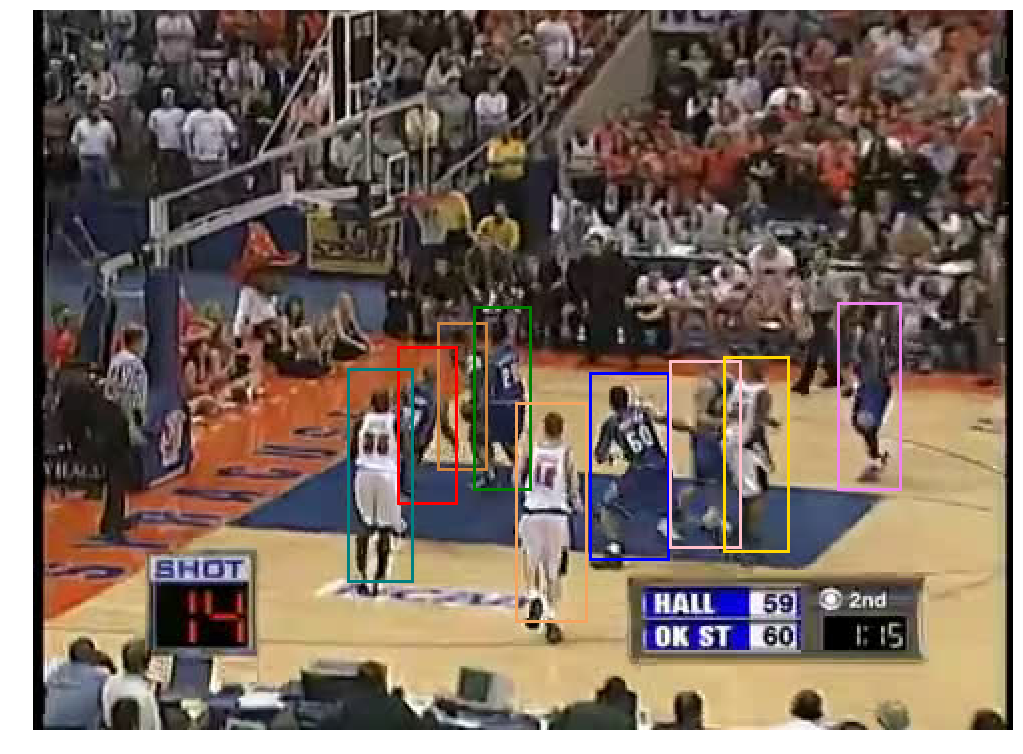

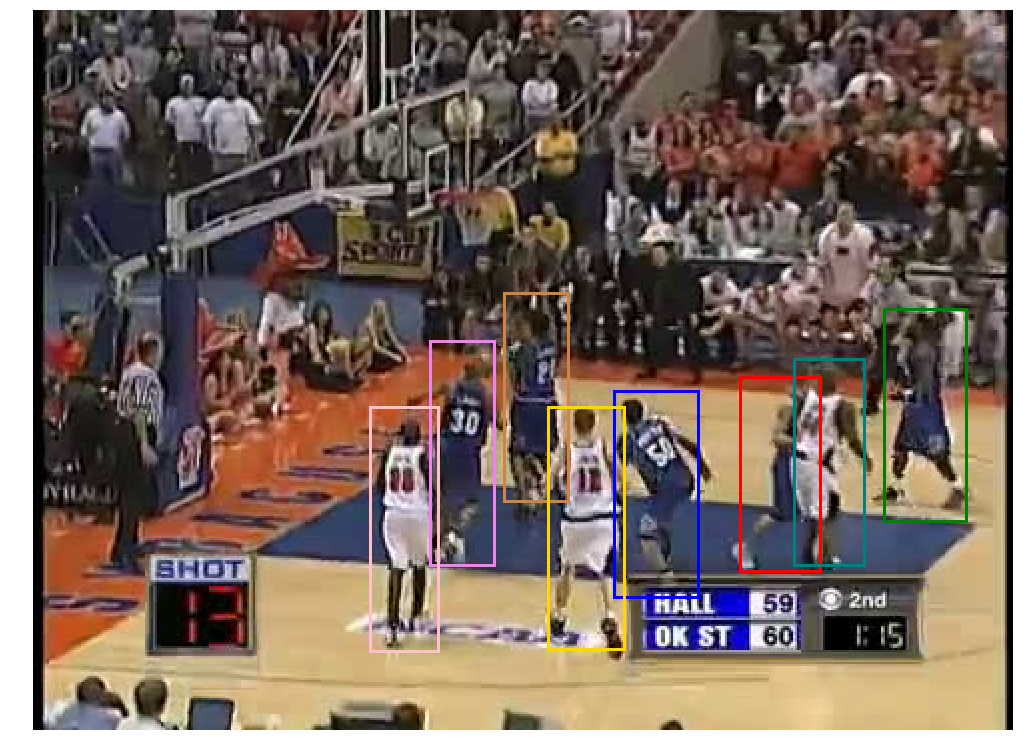

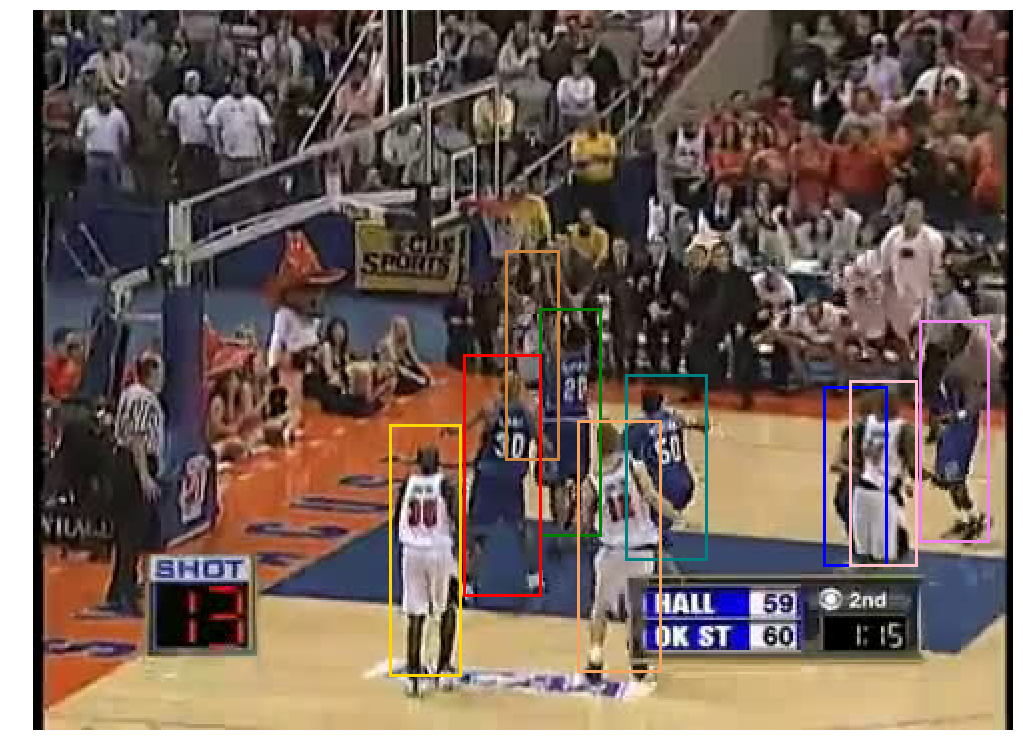

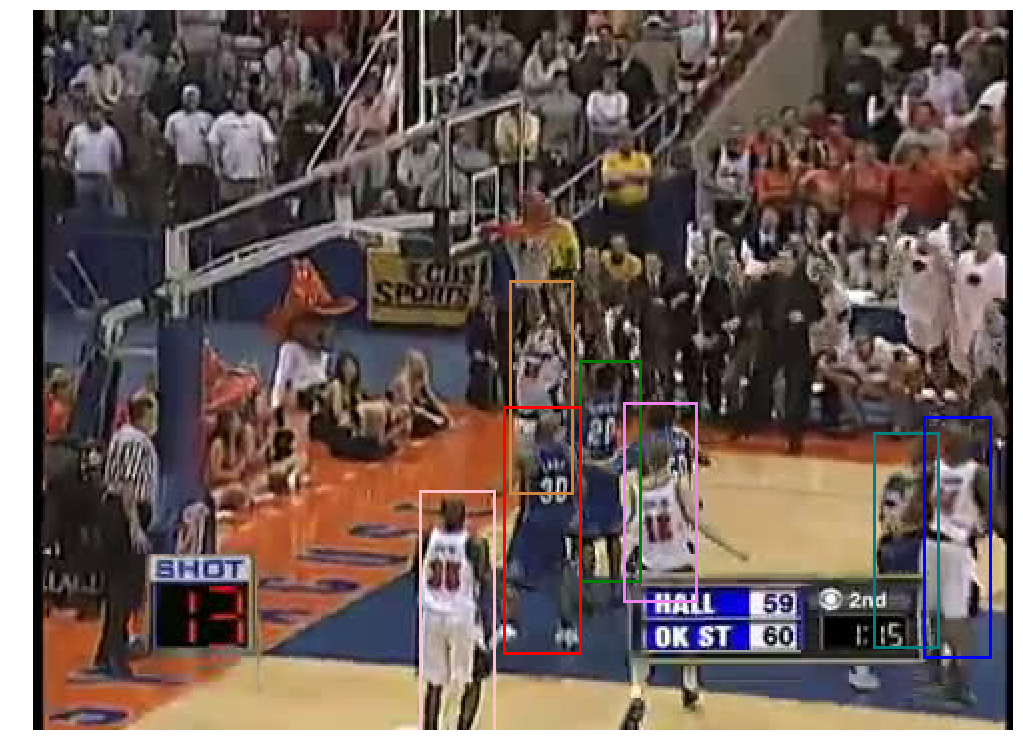

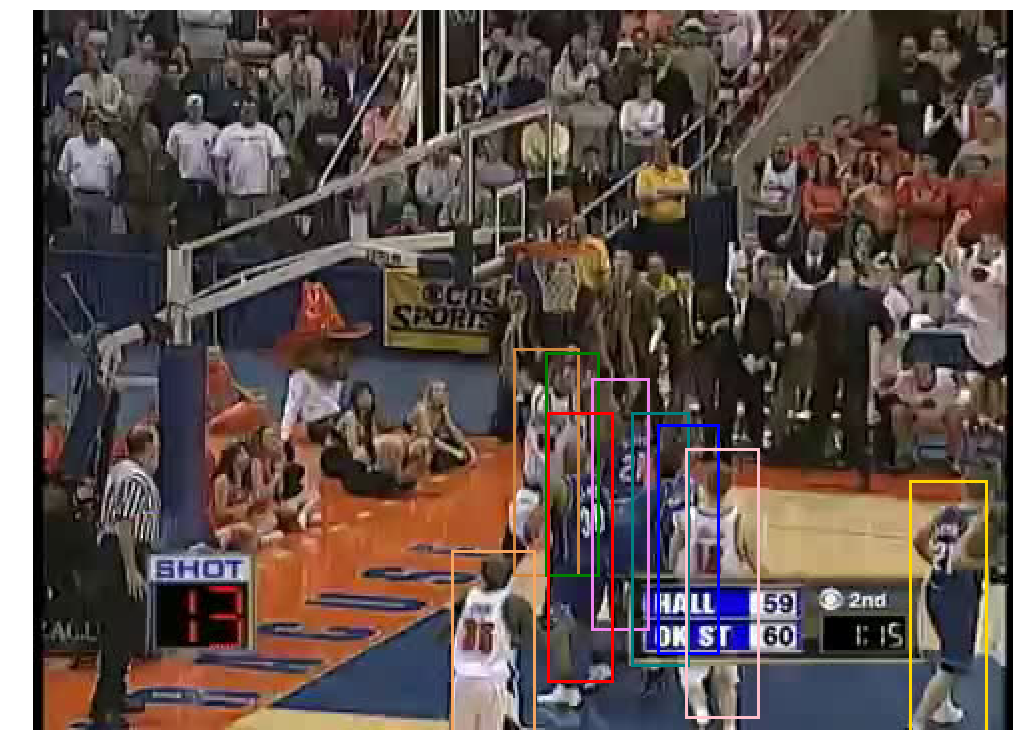

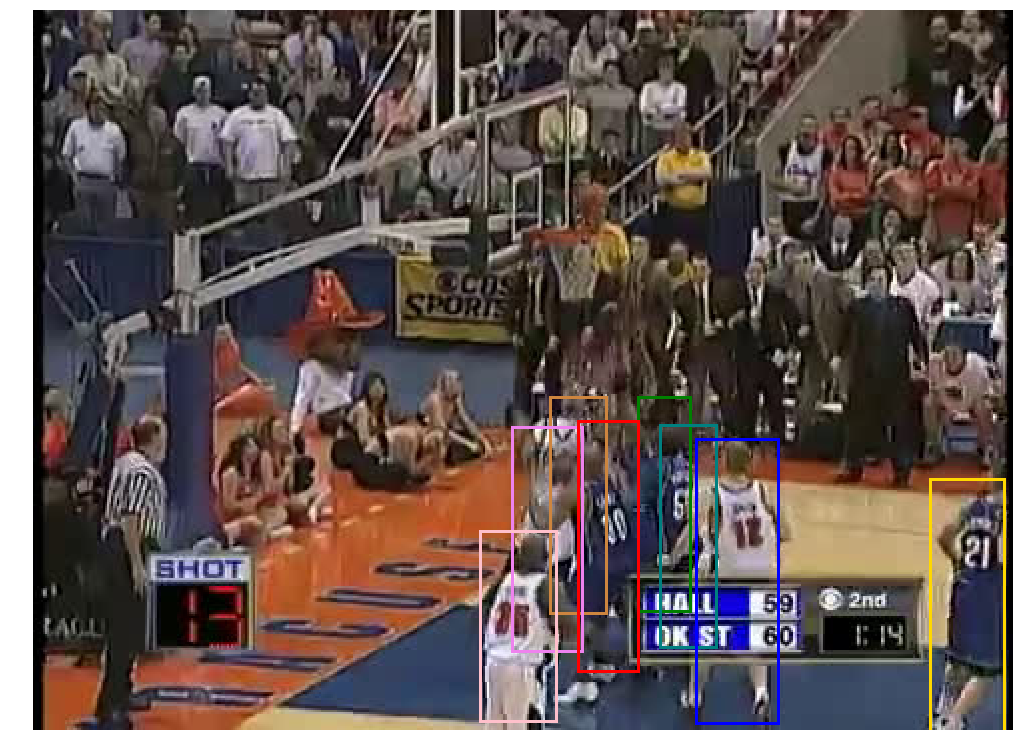

In [473]:
video_id = 'WF0GqBJuBLQ'
clip_id  = 'clip_65'
image_dir = os.path.join(data_dir, video_id, clip_id)
results2 = [name for name in os.listdir(image_dir) if 'png' in name]
results2.sort()

skip_counter = 0
for result in results2:
    result = result.split('.')[0]
    skip_counter = skip_counter + 1
    if skip_counter < 15:
        continue
    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    csv_path = os.path.join(results_dir, csv_name)
    print csv_path
    csv_file = pd.read_csv(csv_path, header = None)

    print overlap_percentage(csv_file)
    produce_image(csv_path, bounding_box = True ,truth = False)

In [432]:
print results

['15.png', '12.png', '20.png', '03.png', '04.png', '13.png', '14.png', '05.png', '02.png', '01.png', '06.png', '08.png', '19.png', '17.png', '10.png', '09.png', '07.png', '11.png', '16.png', '18.png']
